- [8.1.1 Regression Trees](#8.1.1-Regression-Trees)
- [8.1.2 Classification Trees](#8.1.2-Classification-Trees)
- [Lab: 8.3.1 Fitting Classification Trees](#8.3.1-Fitting-Classification-Trees)
- [Lab: 8.3.2 Fitting Regression Trees](#8.3.2-Fitting-Regression-Trees)
- [Lab: 8.3.3 Bagging and Random Forests](#8.3.3-Bagging-and-Random-Forests)
- [Lab: 8.3.4 Boosting](#8.3.4-Boosting)

# Chapter 8 - Tree-based Methods

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import pydot
from IPython.display import Image

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# This function creates images of tree models using pydot
# We did not use it
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

### 8.1.1 Regression Trees

In R, I exported the dataset from package 'ISLR' to a csv file.

In [3]:
df = pd.read_csv('Data/Hitters.csv').dropna()
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


      Unnamed: 0  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
1    -Alan Ashby    315    81      7    24   38     39     14    3449    835   
2   -Alvin Davis    479   130     18    66   72     76      3    1624    457   
3  -Andre Dawson    496   141     20    65   78     37     11    5628   1575   

     ...      CRuns  CRBI  CWalks  League Division PutOuts  Assists  Errors  \
1    ...        321   414     375       N        W     632       43      10   
2    ...        224   266     263       A        W     880       82      14   
3    ...        828   838     354       N        E     200       11       3   

   Salary  NewLeague  
1   475.0          N  
2   480.0          A  
3   500.0          N  

[3 rows x 21 columns]

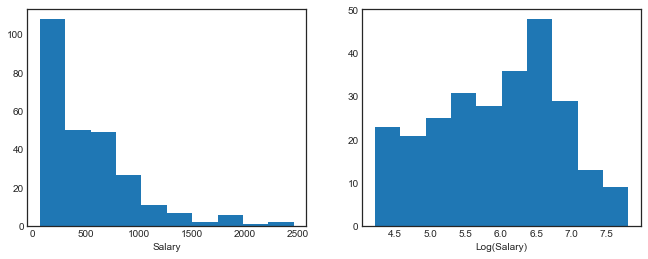

In [4]:
X = df[['Years', 'Hits']].as_matrix()
y = np.log(df.Salary.as_matrix())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(df.Salary.as_matrix())
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

In [5]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### Figure 8.1

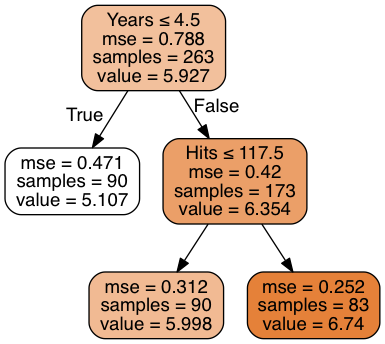

In [6]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(regr, out_file='hitters_tree1.dot',feature_names=['Years','Hits'],
                           filled=True, rounded=True,  
                        special_characters=True)

with open('hitters_tree1.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

###  Figure 8.2

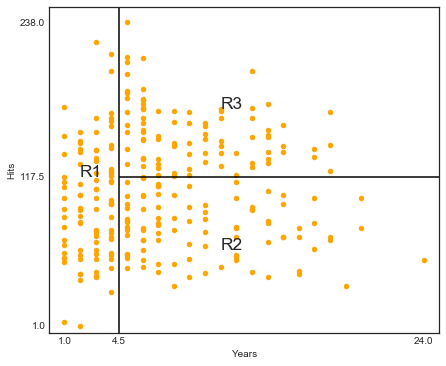

In [7]:
df.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');


### Pruning
Pruning for a classification Tree involves selecting a set of subtrees as a function of a penalization factor $\alpha $ according to the equation 
$$\sum_{m=1}^{|T|}\sum_{i: x_i \in R_m}(y_i-\hat{y})^2+\alpha|T|$$ 
and then using CV to find the optimal subtree. Sklearn does not provide any methods in their tree class to accomplish pruning. To implement this, we would need to develop a way to prune the returned tree object from sklearn. This is currently not supported in scikit-learn. See first point under 'disadvantages of decision trees in the <A href='http://scikit-learn.github.io/dev/modules/tree.html#'>documentation</A>. Implementation has been <A href='https://github.com/scikit-learn/scikit-learn/pull/941'>discussed</A> but Random Forests have better predictive qualities than a single pruned tree anyway if I understand correctly.
Since, pruned trees are not as competitive, in terms of predictive accuracy, with other models we will move on. I hope to come back to this and add this functionality to sklearn. It appears to be the first time in the ISLR book that we have hit a method where statsmodels or sklearn can not accomplish the same task as R.



    

### 8.1.2 Classification Trees

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [8]:
df2 = pd.read_csv('Data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
df2.info()
df2.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
Age          297 non-null int64
Sex          297 non-null int64
ChestPain    297 non-null object
RestBP       297 non-null int64
Chol         297 non-null int64
Fbs          297 non-null int64
RestECG      297 non-null int64
MaxHR        297 non-null int64
ExAng        297 non-null int64
Oldpeak      297 non-null float64
Slope        297 non-null int64
Ca           297 non-null float64
Thal         297 non-null object
AHD          297 non-null object
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


   Age  Sex     ChestPain  RestBP  Chol  Fbs  RestECG  MaxHR  ExAng  Oldpeak  \
0   63    1       typical     145   233    1        2    150      0      2.3   
1   67    1  asymptomatic     160   286    0        2    108      1      1.5   
2   67    1  asymptomatic     120   229    0        2    129      1      2.6   

   Slope   Ca        Thal  AHD  
0      3  0.0       fixed   No  
1      2  3.0      normal  Yes  
2      2  2.0  reversable  Yes  

In [9]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [10]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [11]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)
clf.fit(X2,y2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=6, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [12]:
clf.score(X2,y2)

0.76094276094276092

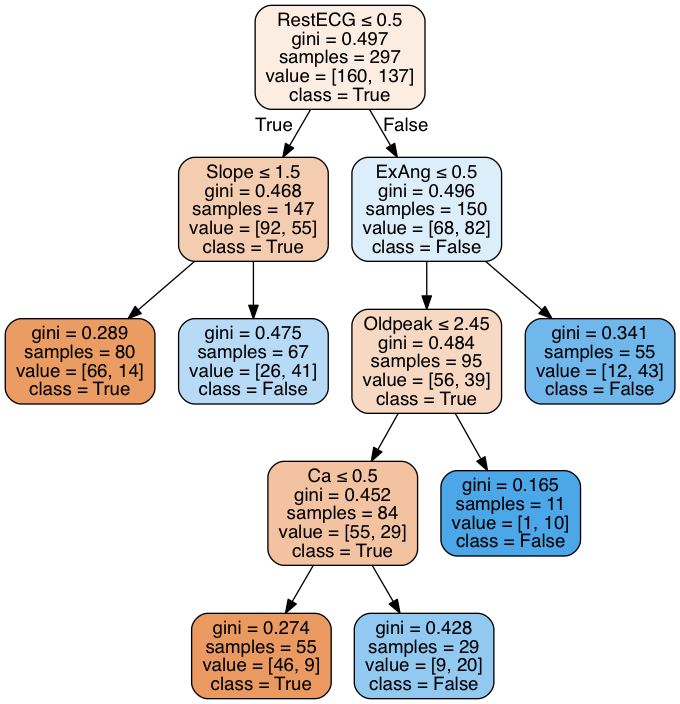

In [13]:
#graph2 = print_tree(clf, features=X2.columns, class_names=['No', 'Yes'])
#Image(graph2.create_png())
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(clf, out_file='heart_tree.dot',feature_names=X2.columns,
                           class_names=['True', 'False'], filled=True, rounded=True,  
                        special_characters=True)

with open('heart_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

## Lab

### 8.3.1 Fitting Classification Trees

In R, I exported the dataset from package 'ISLR' to a csv file.

In [14]:
df3 = pd.read_csv('Data/Carseats.csv').drop('Unnamed: 0', axis=1)
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null object
Age            400 non-null int64
Education      400 non-null int64
Urban          400 non-null object
US             400 non-null object
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  

In [15]:
# create a new column called High, a boolean for if sales > 8
df3['High'] = df3.Sales > 8
df3 = pd.get_dummies(df3, columns=['ShelveLoc', 'Urban', 'US'])
# drop the unnecessary columns -- remember the number of dummies is always one less than the number of levels
#df3 = df3.drop(['ShelveLoc_Bad', 'Urban_No', 'US_No'],axis=1)


# Another way to do this:
#df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
#df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]
# df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
# df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 16 columns):
Sales               400 non-null float64
CompPrice           400 non-null int64
Income              400 non-null int64
Advertising         400 non-null int64
Population          400 non-null int64
Price               400 non-null int64
Age                 400 non-null int64
Education           400 non-null int64
High                400 non-null bool
ShelveLoc_Bad       400 non-null uint8
ShelveLoc_Good      400 non-null uint8
ShelveLoc_Medium    400 non-null uint8
Urban_No            400 non-null uint8
Urban_Yes           400 non-null uint8
US_No               400 non-null uint8
US_Yes              400 non-null uint8
dtypes: bool(1), float64(1), int64(7), uint8(7)
memory usage: 28.2 KB


In [16]:
df3.head(5)

   Sales  CompPrice  Income  Advertising  Population  Price  Age  Education  \
0   9.50        138      73           11         276    120   42         17   
1  11.22        111      48           16         260     83   65         10   
2  10.06        113      35           10         269     80   59         12   
3   7.40        117     100            4         466     97   55         14   
4   4.15        141      64            3         340    128   38         13   

    High  ShelveLoc_Bad  ShelveLoc_Good  ShelveLoc_Medium  Urban_No  \
0   True              1               0                 0         0   
1   True              0               1                 0         0   
2   True              0               0                 1         0   
3  False              0               0                 1         0   
4  False              1               0                 0         0   

   Urban_Yes  US_No  US_Yes  
0          1      0       1  
1          1      0       1  
2       

In [17]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

In [18]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [19]:
print(classification_report(y, clf.predict(X)))

             precision    recall  f1-score   support

      False       0.88      1.00      0.94       236
       True       0.99      0.81      0.89       164

avg / total       0.93      0.92      0.92       400



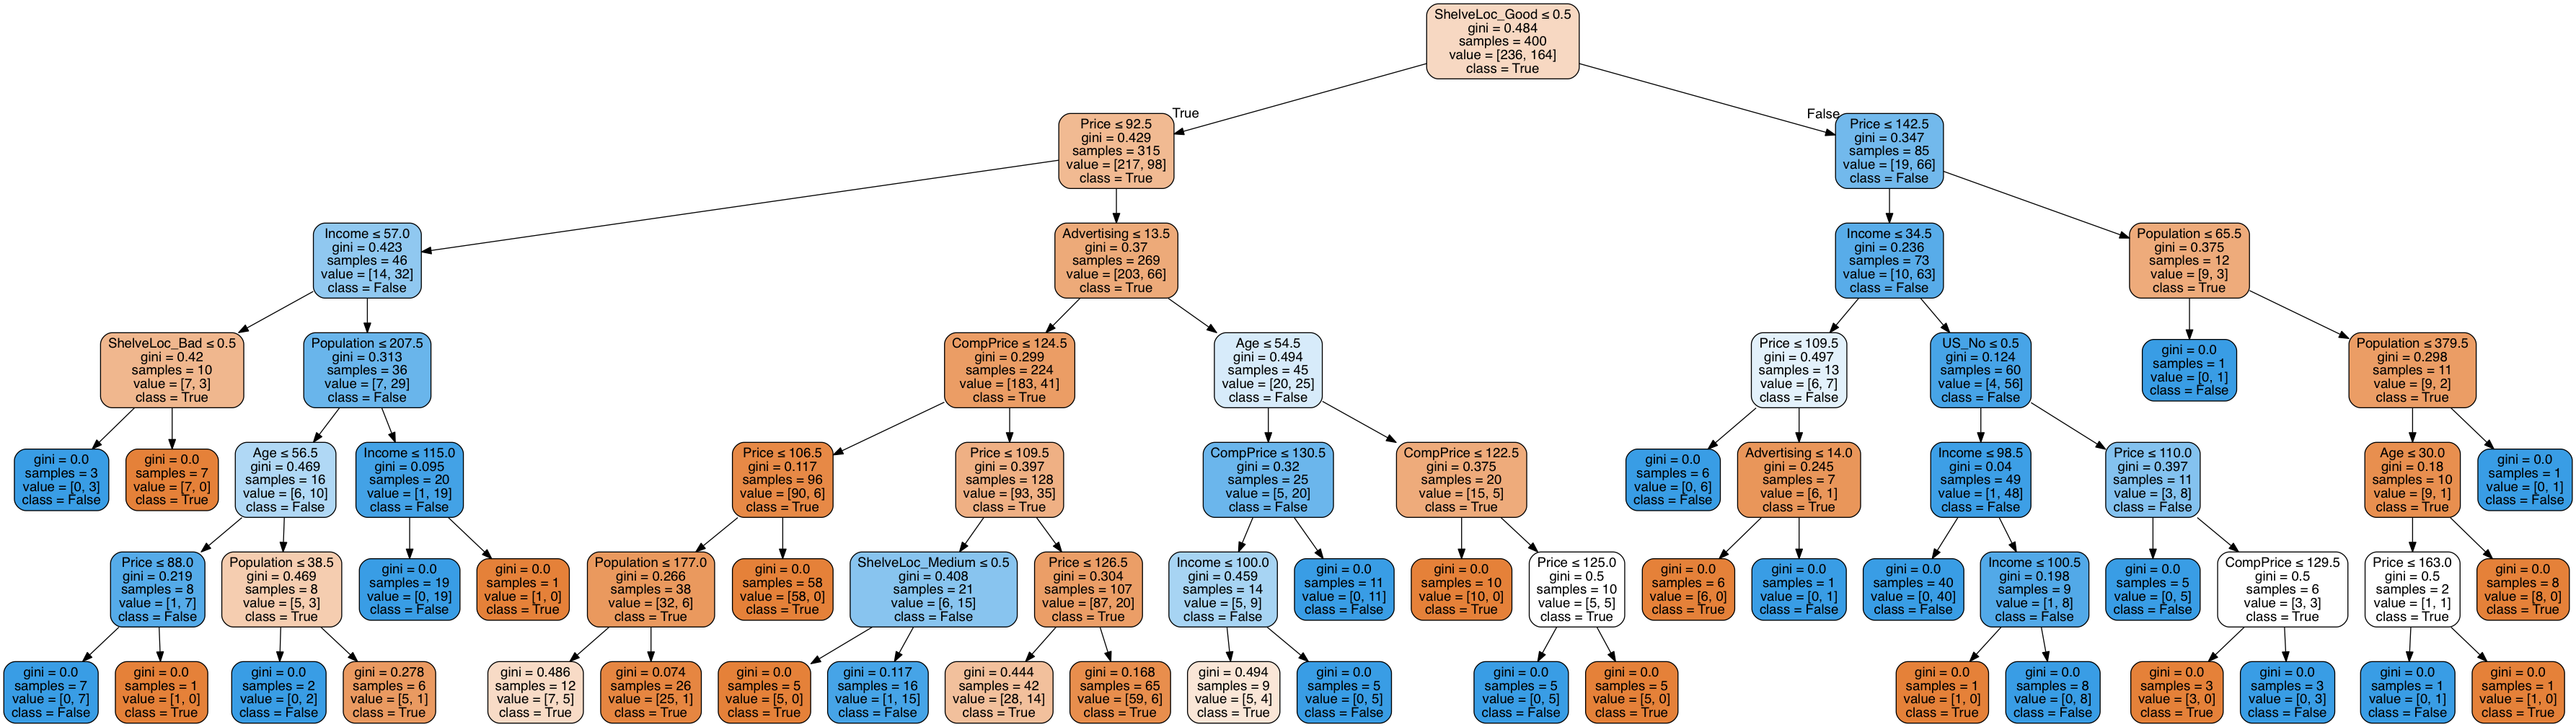

In [20]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(clf, out_file='seat_tree.dot',feature_names=X_train.columns, 
                class_names=['True', 'False'],filled=True, rounded=True,  
                        special_characters=True)

with open('seat_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

In [21]:
# also show the view of the source object in browser so we can zoom in on nodes and see what we've got
I.view()

'Source.gv.png'

In [22]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [23]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True       No  Yes
Predicted         
No         99   29
Yes        19   53

In [24]:
# Precision of the model using test data is 74%
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

      False       0.77      0.84      0.80       118
       True       0.74      0.65      0.69        82

avg / total       0.76      0.76      0.76       200



Pruning not implemented in scikit-learn.

### 8.3.2 Fitting Regression Trees

In R, I exported the dataset from package 'MASS' to a csv file.

In [25]:
boston_df = pd.read_csv('Data/Boston.csv')
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB


In [26]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

In [27]:
# Pruning not supported. Choosing max depth 3)
regr2 = DecisionTreeRegressor(max_depth=3)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)

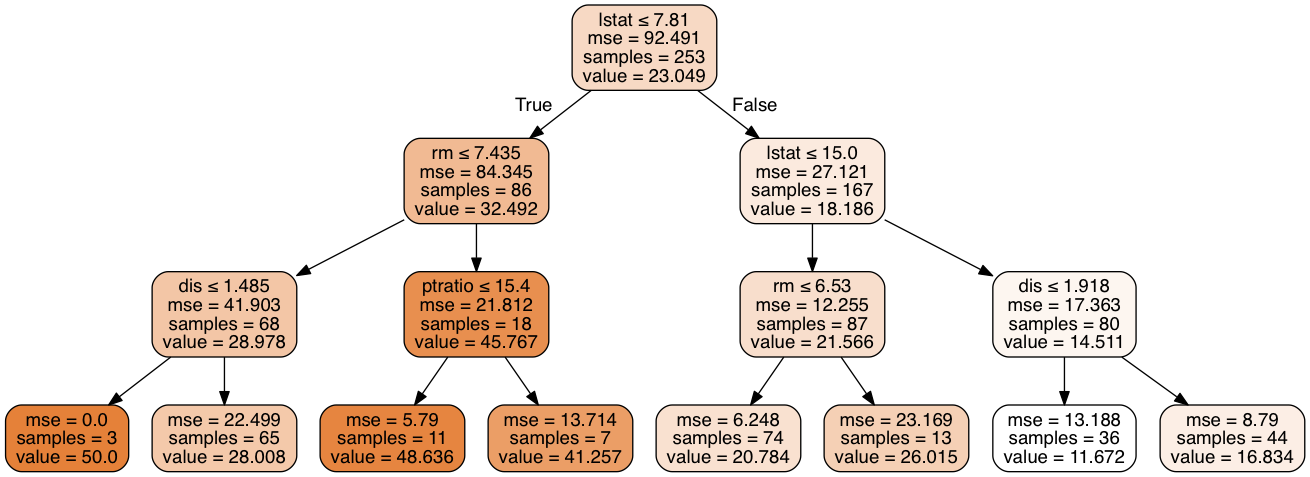

In [28]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(regr2, out_file='boston_tree.dot',feature_names=X_train.columns,
                           filled=True, rounded=True, special_characters=True)

with open('boston_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

For suburbs with lstat < 7.81 and rm > 7.44 the tree predicts a median home value of $45,766; a value that is very close to the labs value of 46,400.

Text(0,0.5,'y_test')

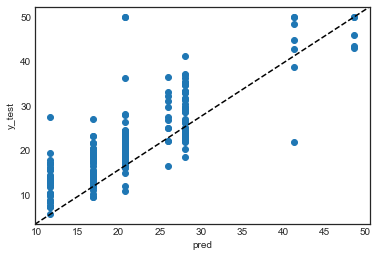

In [29]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [30]:
mean_squared_error(y_test, pred)

26.023230850097448

### 8.3.3 Bagging and Random Forests

In [31]:
# There are 13 features in the dataset
X.shape

(506, 13)

In [32]:
# Bagging: using all features
regr1 = RandomForestRegressor(max_features=13, random_state=1)
regr1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=13, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

Text(0,0.5,'y_test')

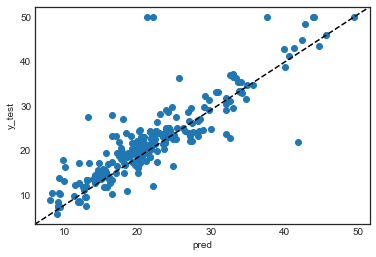

In [33]:
pred = regr1.predict(X_test)

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [34]:
mean_squared_error(y_test, pred)

18.301366007905138

In [35]:
# Random forests: using 6 features
regr2 = RandomForestRegressor(max_features=6, random_state=1)
regr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [36]:
pred = regr2.predict(X_test)
mean_squared_error(y_test, pred)

16.469374703557314

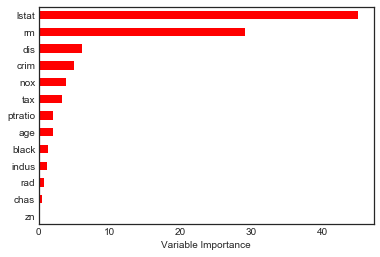

In [37]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### 8.3.4 Boosting

In [38]:
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

lstat      27.024410
rm         22.134290
dis        10.248698
ptratio     8.226473
crim        6.750284
age         5.587239
black       5.082208
tax         5.007437
nox         3.284683
indus       3.045285
chas        1.844703
rad         1.593909
zn          0.170382
dtype: float64
13


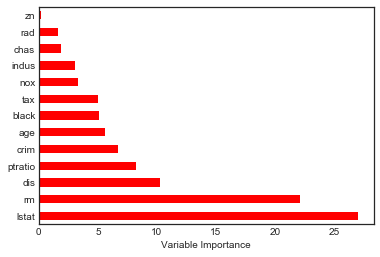

In [39]:
#feature_importance = regr.feature_importances_*100


feature_importance = pd.Series(data=regr.feature_importances_*100, index=list(X.columns))
rel_imp = feature_importance.sort_values(ascending=False) #(inplace=False)
print(rel_imp)
print(len(rel_imp))
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [40]:
mean_squared_error(y_test, regr.predict(X_test))

15.529710264059759

### Partial Dependence Plot
One of the advantages of parametric statistical learning methods such as linear regression is that we can easily interpret the effect of a single predictor on the model by examing each covariates coeffecients. With boosted decision trees interpreting a model can be difficult. One method is to consider partial dependence plots.

A partial dependence plot examines the effect of single predictor after averaging out the effect of all other predictors. Please see https://cran.r-project.org/web/packages/datarobot/vignettes/PartialDependence.html. Briefly recall that our estimate for the response y can be written as ${\hat{y}}_k = F(x_{1k}, x_{2k},...x_{pk}$ where k is the number of observations and p is the covariate number. Now lets suppose that we average all the ${\hat{y}}_k$ except for one covariate which we leave free to vary. We can write this as $\phi_j(x) = \frac{1}{N} \sum_{k=1}^{N} F(x_{1,k}, x_{2,k},...x_{j-1,k},x, x_{j+1,k},...x_{p,k})$. This is equivalent to writing $\phi_j(x) = \frac{1}{N}(\hat{y}_1 + \hat{y}_2 + ... y_j(x) + .... \hat{y}_p)$. So what $\phi_j(x)$ represents is the effect of the jth covariate after averaging out the effects from all the other covariates. Note there is a drawback in that it will miss interaction effects. Sklearn provides the functionality we require to make a plot of $\phi_j(x)$.

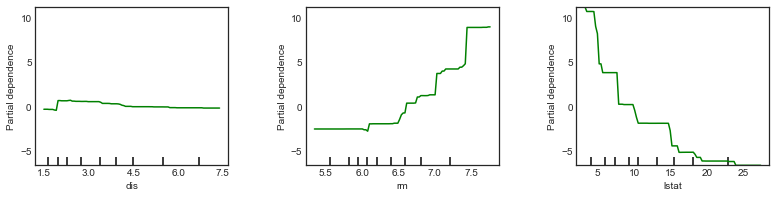

In [41]:
# Get the three feature indexes with the highest importance (lstat, rm, dis)
feature_idxs=np.argsort(feature_importance.values)[-3:]
# Create the PDP
fig, axs = plt.subplots(1,1, figsize=(12,4))
plot_partial_dependence(regr, X_train, features=feature_idxs, 
                                    feature_names=feature_importance.index.tolist(), ax=axs);

This plots make sense with what we know about this dataset from previous labs. Increasing number of rooms increases the medv and decreasing lstat ( a poverty measure) increases medv.